markstro
3/27/2020

This notebook is for estimating the parameter "dday_slope" for GF v1.1



Compute the daily radadj value for each HRU for each day

In [1]:
import numpy as np
import pandas as pd
import fiona 
import geopandas as gpd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
nrel_shapefile_fn = "c:/Users/markstro/work1.1/GIS/nhm_shapefiles/nhm_hru_gf1_1_nrel_solrad.shp"

# This file produced by jupyter notebook "solar_table". It produces the same values as the soltab.f90 PRMS module.
soltab_solt_fn = 'c:/Users/markstro/work1.1/soltab/soltab_solt_GF_v1.1.csv'

# This is the hru_slope value from the PRMS parameter file
hru_slope_fn = 'c:/Users/markstro/work/input/hru_slope.csv'

gdb_path = 'c:/Users/markstro/work1.1/GIS/GFv1.1_v2e.gdb'

# This is the hru_slope value from the PRMS parameter file
hru_elev_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_elev.csv'
hru_slope_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_slope.csv'
hru_aspect_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_aspect.csv'

In [3]:
coolwarm = cm.get_cmap('coolwarm', 12)
print(coolwarm)

# Next blocks load in the monthly solrad targets from NREL Direct Normal Irradiance from http://nrel.gov/gis/solar.html

In [4]:
# Read in the monthly short wave data from NREL

hrus = gpd.read_file(nrel_shapefile_fn)

In [5]:
hrus.head()

,OBJECTID,nhru_v11,hru_segmen,nhm_id,hru_id_nat,Version,Shape_Leng,Shape_Area,dni_jan_me,dni_feb_me,...,dni_apr_me,dni_may_me,dni_jun_me,dni_jul_me,dni_aug_me,dni_sep_me,dni_oct_me,dni_nov_me,dni_dec_me,geometry
0,1.0,76127,40038,76128,76128,1,92601.509382,1.881513e+08,182.201489,183.518720,...,207.460355,214.931469,256.187361,261.887199,257.431331,232.848366,229.749484,196.082145,166.266536,"POLYGON ((-105544.567 804074.976, -105542.972 ..."
1,2.0,76147,40038,76148,76148,1,60460.683381,4.416189e+07,182.087354,182.827321,...,207.058857,213.263005,254.263475,261.069763,255.607433,231.055495,227.661986,193.967239,164.803657,"POLYGON ((-97185.217 806355.005, -97184.805 80..."
2,3.0,76170,40021,76171,76171,1,62333.253245,7.337575e+07,183.556248,184.545532,...,207.761440,214.004899,256.235609,263.360321,258.373488,232.371546,228.184034,194.836239,165.232111,"MULTIPOLYGON (((-106590.453 815804.909, -10646..."
3,4.0,76172,40019,76173,76173,1,36798.115971,3.627274e+07,184.019112,185.748908,...,209.134271,213.834536,256.499269,263.734024,259.503738,232.098319,228.484543,195.671808,164.857940,"POLYGON ((-106762.641 815925.020, -106754.831 ..."
4,5.0,76181,40019,76182,76182,1,31441.172667,1.564925e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109785.311 816675.047, -109784.942 ..."


In [6]:
nhru_v11_vals = hrus["nhru_v11"]
print(nhru_v11_vals)

0         76127
1         76147
2         76170
3         76172
4         76181
          ...  
114953    57964
114954    64080
114955    64150
114956    65633
114957    18843
Name: nhru_v11, Length: 114958, dtype: int64


In [7]:
mapback_nhrm_v11_vals = np.zeros(len(nhru_v11_vals), dtype="int")

for ii in range(len(nhru_v11_vals)):
    mapback_nhrm_v11_vals[ii] = nhru_v11_vals[ii]

In [8]:
# For whatever reason, the zonal mean process from QGIS left some NaNs when filling in the Direct Normal Irradiance (dni)
# monthly values when filling out the shapefile (see dni* columns above). Those need to be filled in with real values.
# Without going back to the GIS (which I already ran with the results that are shown above), I am using np.interpolate across
# each column. This is a hack in the sense that the adjacent row do not necessarily mean that the HRUs are adjacent, and it
# is uncertain at this time exactly what is being interpolated, but it is filling in the nan values with real values and allows
# me to move on.


print(hrus.shape)

print("original coordinates with nan value")
count = 0
for ii in range(hrus.shape[0]):
    for jj in range(8,20):
        if np.isnan(hrus.iloc[ii,jj]):
            print(" (", ii,jj, ")", end = '')
            count += 1
print("")
print(count)
      

for ii in range(hrus.shape[0]):
    for jj in range(8,20):
        hrus.iloc[:,jj] = hrus.iloc[:,jj].interpolate()

print("subsequent coordinates with nan value")
count = 0
for ii in range(hrus.shape[0]):
    for jj in range(8,20):
        if np.isnan(hrus.iloc[ii,jj]):
            print(" (", ii,jj, ")", end = '')
            count += 1

print("")
print(count)


(114958, 21)
original coordinates with nan value


 ( 4 8 ) ( 4 9 ) ( 4 10 ) ( 4 11 ) ( 4 12 ) ( 4 13 ) ( 4 14 ) ( 4 15 ) ( 4 16 ) ( 4 17 ) ( 4 18 ) ( 4 19 ) ( 54 8 ) ( 54 9 ) ( 54 10 ) ( 54 11 ) ( 54 12 ) ( 54 13 ) ( 54 14 ) ( 54 15 ) ( 54 16 ) ( 54 17 ) ( 54 18 ) ( 54 19 ) ( 250 8 ) ( 250 9 ) ( 250 10 ) ( 250 11 ) ( 250 12 ) ( 250 13 ) ( 250 14 ) ( 250 15 ) ( 250 16 ) ( 250 17 ) ( 250 18 ) ( 250 19 ) ( 290 8 ) ( 290 9 ) ( 290 10 ) ( 290 11 ) ( 290 12 ) ( 290 13 ) ( 290 14 ) ( 290 15 ) ( 290 16 ) ( 290 17 ) ( 290 18 ) ( 290 19 ) ( 416 8 ) ( 416 9 ) ( 416 10 ) ( 416 11 ) ( 416 12 ) ( 416 13 ) ( 416 14 ) ( 416 15 ) ( 416 16 ) ( 416 17 ) ( 416 18 ) ( 416 19 ) ( 436 8 ) ( 436 9 ) ( 436 10 ) ( 436 11 ) ( 436 12 ) ( 436 13 ) ( 436 14 ) ( 436 15 ) ( 436 16 ) ( 436 17 ) ( 436 18 ) ( 436 19 ) ( 470 8 ) ( 470 9 ) ( 470 10 ) ( 470 11 ) ( 470 12 ) ( 470 13 ) ( 470 14 ) ( 470 15 ) ( 470 16 ) ( 470 17 ) ( 470 18 ) ( 470 19 ) ( 478 8 ) ( 478 9 ) ( 478 10 ) ( 478 11 ) ( 478 12 ) ( 478 13 ) ( 478 14 ) ( 478 15 ) ( 478 16 ) ( 478 17 ) ( 478 18 ) ( 478 

 ( 5207 15 ) ( 5207 16 ) ( 5207 17 ) ( 5207 18 ) ( 5207 19 ) ( 5241 8 ) ( 5241 9 ) ( 5241 10 ) ( 5241 11 ) ( 5241 12 ) ( 5241 13 ) ( 5241 14 ) ( 5241 15 ) ( 5241 16 ) ( 5241 17 ) ( 5241 18 ) ( 5241 19 ) ( 5260 8 ) ( 5260 9 ) ( 5260 10 ) ( 5260 11 ) ( 5260 12 ) ( 5260 13 ) ( 5260 14 ) ( 5260 15 ) ( 5260 16 ) ( 5260 17 ) ( 5260 18 ) ( 5260 19 ) ( 5381 8 ) ( 5381 9 ) ( 5381 10 ) ( 5381 11 ) ( 5381 12 ) ( 5381 13 ) ( 5381 14 ) ( 5381 15 ) ( 5381 16 ) ( 5381 17 ) ( 5381 18 ) ( 5381 19 ) ( 5743 8 ) ( 5743 9 ) ( 5743 10 ) ( 5743 11 ) ( 5743 12 ) ( 5743 13 ) ( 5743 14 ) ( 5743 15 ) ( 5743 16 ) ( 5743 17 ) ( 5743 18 ) ( 5743 19 ) ( 5976 8 ) ( 5976 9 ) ( 5976 10 ) ( 5976 11 ) ( 5976 12 ) ( 5976 13 ) ( 5976 14 ) ( 5976 15 ) ( 5976 16 ) ( 5976 17 ) ( 5976 18 ) ( 5976 19 ) ( 6174 8 ) ( 6174 9 ) ( 6174 10 ) ( 6174 11 ) ( 6174 12 ) ( 6174 13 ) ( 6174 14 ) ( 6174 15 ) ( 6174 16 ) ( 6174 17 ) ( 6174 18 ) ( 6174 19 ) ( 6274 8 ) ( 6274 9 ) ( 6274 10 ) ( 6274 11 ) ( 6274 12 ) ( 6274 13 ) ( 6274 14 ) ( 627

14 ) ( 11464 15 ) ( 11464 16 ) ( 11464 17 ) ( 11464 18 ) ( 11464 19 ) ( 11488 8 ) ( 11488 9 ) ( 11488 10 ) ( 11488 11 ) ( 11488 12 ) ( 11488 13 ) ( 11488 14 ) ( 11488 15 ) ( 11488 16 ) ( 11488 17 ) ( 11488 18 ) ( 11488 19 ) ( 11645 8 ) ( 11645 9 ) ( 11645 10 ) ( 11645 11 ) ( 11645 12 ) ( 11645 13 ) ( 11645 14 ) ( 11645 15 ) ( 11645 16 ) ( 11645 17 ) ( 11645 18 ) ( 11645 19 ) ( 11927 8 ) ( 11927 9 ) ( 11927 10 ) ( 11927 11 ) ( 11927 12 ) ( 11927 13 ) ( 11927 14 ) ( 11927 15 ) ( 11927 16 ) ( 11927 17 ) ( 11927 18 ) ( 11927 19 ) ( 11967 8 ) ( 11967 9 ) ( 11967 10 ) ( 11967 11 ) ( 11967 12 ) ( 11967 13 ) ( 11967 14 ) ( 11967 15 ) ( 11967 16 ) ( 11967 17 ) ( 11967 18 ) ( 11967 19 ) ( 12160 8 ) ( 12160 9 ) ( 12160 10 ) ( 12160 11 ) ( 12160 12 ) ( 12160 13 ) ( 12160 14 ) ( 12160 15 ) ( 12160 16 ) ( 12160 17 ) ( 12160 18 ) ( 12160 19 ) ( 12219 8 ) ( 12219 9 ) ( 12219 10 ) ( 12219 11 ) ( 12219 12 ) ( 12219 13 ) ( 12219 14 ) ( 12219 15 ) ( 12219 16 ) ( 12219 17 ) ( 12219 18 ) ( 12219 19 ) ( 1222

 ( 18152 8 ) ( 18152 9 ) ( 18152 10 ) ( 18152 11 ) ( 18152 12 ) ( 18152 13 ) ( 18152 14 ) ( 18152 15 ) ( 18152 16 ) ( 18152 17 ) ( 18152 18 ) ( 18152 19 ) ( 18378 8 ) ( 18378 9 ) ( 18378 10 ) ( 18378 11 ) ( 18378 12 ) ( 18378 13 ) ( 18378 14 ) ( 18378 15 ) ( 18378 16 ) ( 18378 17 ) ( 18378 18 ) ( 18378 19 ) ( 18568 8 ) ( 18568 9 ) ( 18568 10 ) ( 18568 11 ) ( 18568 12 ) ( 18568 13 ) ( 18568 14 ) ( 18568 15 ) ( 18568 16 ) ( 18568 17 ) ( 18568 18 ) ( 18568 19 ) ( 19065 8 ) ( 19065 9 ) ( 19065 10 ) ( 19065 11 ) ( 19065 12 ) ( 19065 13 ) ( 19065 14 ) ( 19065 15 ) ( 19065 16 ) ( 19065 17 ) ( 19065 18 ) ( 19065 19 ) ( 19070 8 ) ( 19070 9 ) ( 19070 10 ) ( 19070 11 ) ( 19070 12 ) ( 19070 13 ) ( 19070 14 ) ( 19070 15 ) ( 19070 16 ) ( 19070 17 ) ( 19070 18 ) ( 19070 19 ) ( 19071 8 ) ( 19071 9 ) ( 19071 10 ) ( 19071 11 ) ( 19071 12 ) ( 19071 13 ) ( 19071 14 ) ( 19071 15 ) ( 19071 16 ) ( 19071 17 ) ( 19071 18 ) ( 19071 19 ) ( 19096 8 ) ( 19096 9 ) ( 19096 10 ) ( 19096 11 ) ( 19096 12 ) ( 19096 13 )

 20807 8 ) ( 20807 9 ) ( 20807 10 ) ( 20807 11 ) ( 20807 12 ) ( 20807 13 ) ( 20807 14 ) ( 20807 15 ) ( 20807 16 ) ( 20807 17 ) ( 20807 18 ) ( 20807 19 ) ( 20829 8 ) ( 20829 9 ) ( 20829 10 ) ( 20829 11 ) ( 20829 12 ) ( 20829 13 ) ( 20829 14 ) ( 20829 15 ) ( 20829 16 ) ( 20829 17 ) ( 20829 18 ) ( 20829 19 ) ( 20889 8 ) ( 20889 9 ) ( 20889 10 ) ( 20889 11 ) ( 20889 12 ) ( 20889 13 ) ( 20889 14 ) ( 20889 15 ) ( 20889 16 ) ( 20889 17 ) ( 20889 18 ) ( 20889 19 ) ( 20906 8 ) ( 20906 9 ) ( 20906 10 ) ( 20906 11 ) ( 20906 12 ) ( 20906 13 ) ( 20906 14 ) ( 20906 15 ) ( 20906 16 ) ( 20906 17 ) ( 20906 18 ) ( 20906 19 ) ( 21016 8 ) ( 21016 9 ) ( 21016 10 ) ( 21016 11 ) ( 21016 12 ) ( 21016 13 ) ( 21016 14 ) ( 21016 15 ) ( 21016 16 ) ( 21016 17 ) ( 21016 18 ) ( 21016 19 ) ( 21075 8 ) ( 21075 9 ) ( 21075 10 ) ( 21075 11 ) ( 21075 12 ) ( 21075 13 ) ( 21075 14 ) ( 21075 15 ) ( 21075 16 ) ( 21075 17 ) ( 21075 18 ) ( 21075 19 ) ( 21208 8 ) ( 21208 9 ) ( 21208 10 ) ( 21208 11 ) ( 21208 12 ) ( 21208 13 ) (

 ) ( 23941 11 ) ( 23941 12 ) ( 23941 13 ) ( 23941 14 ) ( 23941 15 ) ( 23941 16 ) ( 23941 17 ) ( 23941 18 ) ( 23941 19 ) ( 24014 8 ) ( 24014 9 ) ( 24014 10 ) ( 24014 11 ) ( 24014 12 ) ( 24014 13 ) ( 24014 14 ) ( 24014 15 ) ( 24014 16 ) ( 24014 17 ) ( 24014 18 ) ( 24014 19 ) ( 24031 8 ) ( 24031 9 ) ( 24031 10 ) ( 24031 11 ) ( 24031 12 ) ( 24031 13 ) ( 24031 14 ) ( 24031 15 ) ( 24031 16 ) ( 24031 17 ) ( 24031 18 ) ( 24031 19 ) ( 24061 8 ) ( 24061 9 ) ( 24061 10 ) ( 24061 11 ) ( 24061 12 ) ( 24061 13 ) ( 24061 14 ) ( 24061 15 ) ( 24061 16 ) ( 24061 17 ) ( 24061 18 ) ( 24061 19 ) ( 24066 8 ) ( 24066 9 ) ( 24066 10 ) ( 24066 11 ) ( 24066 12 ) ( 24066 13 ) ( 24066 14 ) ( 24066 15 ) ( 24066 16 ) ( 24066 17 ) ( 24066 18 ) ( 24066 19 ) ( 24184 8 ) ( 24184 9 ) ( 24184 10 ) ( 24184 11 ) ( 24184 12 ) ( 24184 13 ) ( 24184 14 ) ( 24184 15 ) ( 24184 16 ) ( 24184 17 ) ( 24184 18 ) ( 24184 19 ) ( 24257 8 ) ( 24257 9 ) ( 24257 10 ) ( 24257 11 ) ( 24257 12 ) ( 24257 13 ) ( 24257 14 ) ( 24257 15 ) ( 24257 

 ) ( 28110 10 ) ( 28110 11 ) ( 28110 12 ) ( 28110 13 ) ( 28110 14 ) ( 28110 15 ) ( 28110 16 ) ( 28110 17 ) ( 28110 18 ) ( 28110 19 ) ( 28175 8 ) ( 28175 9 ) ( 28175 10 ) ( 28175 11 ) ( 28175 12 ) ( 28175 13 ) ( 28175 14 ) ( 28175 15 ) ( 28175 16 ) ( 28175 17 ) ( 28175 18 ) ( 28175 19 ) ( 28232 8 ) ( 28232 9 ) ( 28232 10 ) ( 28232 11 ) ( 28232 12 ) ( 28232 13 ) ( 28232 14 ) ( 28232 15 ) ( 28232 16 ) ( 28232 17 ) ( 28232 18 ) ( 28232 19 ) ( 28246 8 ) ( 28246 9 ) ( 28246 10 ) ( 28246 11 ) ( 28246 12 ) ( 28246 13 ) ( 28246 14 ) ( 28246 15 ) ( 28246 16 ) ( 28246 17 ) ( 28246 18 ) ( 28246 19 ) ( 28360 8 ) ( 28360 9 ) ( 28360 10 ) ( 28360 11 ) ( 28360 12 ) ( 28360 13 ) ( 28360 14 ) ( 28360 15 ) ( 28360 16 ) ( 28360 17 ) ( 28360 18 ) ( 28360 19 ) ( 28392 8 ) ( 28392 9 ) ( 28392 10 ) ( 28392 11 ) ( 28392 12 ) ( 28392 13 ) ( 28392 14 ) ( 28392 15 ) ( 28392 16 ) ( 28392 17 ) ( 28392 18 ) ( 28392 19 ) ( 28435 8 ) ( 28435 9 ) ( 28435 10 ) ( 28435 11 ) ( 28435 12 ) ( 28435 13 ) ( 28435 14 ) ( 28435 

) ( 32223 14 ) ( 32223 15 ) ( 32223 16 ) ( 32223 17 ) ( 32223 18 ) ( 32223 19 ) ( 32262 8 ) ( 32262 9 ) ( 32262 10 ) ( 32262 11 ) ( 32262 12 ) ( 32262 13 ) ( 32262 14 ) ( 32262 15 ) ( 32262 16 ) ( 32262 17 ) ( 32262 18 ) ( 32262 19 ) ( 32357 8 ) ( 32357 9 ) ( 32357 10 ) ( 32357 11 ) ( 32357 12 ) ( 32357 13 ) ( 32357 14 ) ( 32357 15 ) ( 32357 16 ) ( 32357 17 ) ( 32357 18 ) ( 32357 19 ) ( 32362 8 ) ( 32362 9 ) ( 32362 10 ) ( 32362 11 ) ( 32362 12 ) ( 32362 13 ) ( 32362 14 ) ( 32362 15 ) ( 32362 16 ) ( 32362 17 ) ( 32362 18 ) ( 32362 19 ) ( 32363 8 ) ( 32363 9 ) ( 32363 10 ) ( 32363 11 ) ( 32363 12 ) ( 32363 13 ) ( 32363 14 ) ( 32363 15 ) ( 32363 16 ) ( 32363 17 ) ( 32363 18 ) ( 32363 19 ) ( 32398 8 ) ( 32398 9 ) ( 32398 10 ) ( 32398 11 ) ( 32398 12 ) ( 32398 13 ) ( 32398 14 ) ( 32398 15 ) ( 32398 16 ) ( 32398 17 ) ( 32398 18 ) ( 32398 19 ) ( 32444 8 ) ( 32444 9 ) ( 32444 10 ) ( 32444 11 ) ( 32444 12 ) ( 32444 13 ) ( 32444 14 ) ( 32444 15 ) ( 32444 16 ) ( 32444 17 ) ( 32444 18 ) ( 32444 1

 ( 34667 8 ) ( 34667 9 ) ( 34667 10 ) ( 34667 11 ) ( 34667 12 ) ( 34667 13 ) ( 34667 14 ) ( 34667 15 ) ( 34667 16 ) ( 34667 17 ) ( 34667 18 ) ( 34667 19 ) ( 34780 8 ) ( 34780 9 ) ( 34780 10 ) ( 34780 11 ) ( 34780 12 ) ( 34780 13 ) ( 34780 14 ) ( 34780 15 ) ( 34780 16 ) ( 34780 17 ) ( 34780 18 ) ( 34780 19 ) ( 34814 8 ) ( 34814 9 ) ( 34814 10 ) ( 34814 11 ) ( 34814 12 ) ( 34814 13 ) ( 34814 14 ) ( 34814 15 ) ( 34814 16 ) ( 34814 17 ) ( 34814 18 ) ( 34814 19 ) ( 34815 8 ) ( 34815 9 ) ( 34815 10 ) ( 34815 11 ) ( 34815 12 ) ( 34815 13 ) ( 34815 14 ) ( 34815 15 ) ( 34815 16 ) ( 34815 17 ) ( 34815 18 ) ( 34815 19 ) ( 34817 8 ) ( 34817 9 ) ( 34817 10 ) ( 34817 11 ) ( 34817 12 ) ( 34817 13 ) ( 34817 14 ) ( 34817 15 ) ( 34817 16 ) ( 34817 17 ) ( 34817 18 ) ( 34817 19 ) ( 34845 8 ) ( 34845 9 ) ( 34845 10 ) ( 34845 11 ) ( 34845 12 ) ( 34845 13 ) ( 34845 14 ) ( 34845 15 ) ( 34845 16 ) ( 34845 17 ) ( 34845 18 ) ( 34845 19 ) ( 34903 8 ) ( 34903 9 ) ( 34903 10 ) ( 34903 11 ) ( 34903 12 ) ( 34903 13 )

 ( 38785 17 ) ( 38785 18 ) ( 38785 19 ) ( 38846 8 ) ( 38846 9 ) ( 38846 10 ) ( 38846 11 ) ( 38846 12 ) ( 38846 13 ) ( 38846 14 ) ( 38846 15 ) ( 38846 16 ) ( 38846 17 ) ( 38846 18 ) ( 38846 19 ) ( 38855 8 ) ( 38855 9 ) ( 38855 10 ) ( 38855 11 ) ( 38855 12 ) ( 38855 13 ) ( 38855 14 ) ( 38855 15 ) ( 38855 16 ) ( 38855 17 ) ( 38855 18 ) ( 38855 19 ) ( 38895 8 ) ( 38895 9 ) ( 38895 10 ) ( 38895 11 ) ( 38895 12 ) ( 38895 13 ) ( 38895 14 ) ( 38895 15 ) ( 38895 16 ) ( 38895 17 ) ( 38895 18 ) ( 38895 19 ) ( 38973 8 ) ( 38973 9 ) ( 38973 10 ) ( 38973 11 ) ( 38973 12 ) ( 38973 13 ) ( 38973 14 ) ( 38973 15 ) ( 38973 16 ) ( 38973 17 ) ( 38973 18 ) ( 38973 19 ) ( 38999 8 ) ( 38999 9 ) ( 38999 10 ) ( 38999 11 ) ( 38999 12 ) ( 38999 13 ) ( 38999 14 ) ( 38999 15 ) ( 38999 16 ) ( 38999 17 ) ( 38999 18 ) ( 38999 19 ) ( 39073 8 ) ( 39073 9 ) ( 39073 10 ) ( 39073 11 ) ( 39073 12 ) ( 39073 13 ) ( 39073 14 ) ( 39073 15 ) ( 39073 16 ) ( 39073 17 ) ( 39073 18 ) ( 39073 19 ) ( 39606 8 ) ( 39606 9 ) ( 39606 10 )

 ( 42699 8 ) ( 42699 9 ) ( 42699 10 ) ( 42699 11 ) ( 42699 12 ) ( 42699 13 ) ( 42699 14 ) ( 42699 15 ) ( 42699 16 ) ( 42699 17 ) ( 42699 18 ) ( 42699 19 ) ( 42711 8 ) ( 42711 9 ) ( 42711 10 ) ( 42711 11 ) ( 42711 12 ) ( 42711 13 ) ( 42711 14 ) ( 42711 15 ) ( 42711 16 ) ( 42711 17 ) ( 42711 18 ) ( 42711 19 ) ( 42829 8 ) ( 42829 9 ) ( 42829 10 ) ( 42829 11 ) ( 42829 12 ) ( 42829 13 ) ( 42829 14 ) ( 42829 15 ) ( 42829 16 ) ( 42829 17 ) ( 42829 18 ) ( 42829 19 ) ( 42844 8 ) ( 42844 9 ) ( 42844 10 ) ( 42844 11 ) ( 42844 12 ) ( 42844 13 ) ( 42844 14 ) ( 42844 15 ) ( 42844 16 ) ( 42844 17 ) ( 42844 18 ) ( 42844 19 ) ( 42913 8 ) ( 42913 9 ) ( 42913 10 ) ( 42913 11 ) ( 42913 12 ) ( 42913 13 ) ( 42913 14 ) ( 42913 15 ) ( 42913 16 ) ( 42913 17 ) ( 42913 18 ) ( 42913 19 ) ( 43156 8 ) ( 43156 9 ) ( 43156 10 ) ( 43156 11 ) ( 43156 12 ) ( 43156 13 ) ( 43156 14 ) ( 43156 15 ) ( 43156 16 ) ( 43156 17 ) ( 43156 18 ) ( 43156 19 ) ( 43362 8 ) ( 43362 9 ) ( 43362 10 ) ( 43362 11 ) ( 43362 12 ) ( 43362 13 )

 ( 46848 8 ) ( 46848 9 ) ( 46848 10 ) ( 46848 11 ) ( 46848 12 ) ( 46848 13 ) ( 46848 14 ) ( 46848 15 ) ( 46848 16 ) ( 46848 17 ) ( 46848 18 ) ( 46848 19 ) ( 46850 8 ) ( 46850 9 ) ( 46850 10 ) ( 46850 11 ) ( 46850 12 ) ( 46850 13 ) ( 46850 14 ) ( 46850 15 ) ( 46850 16 ) ( 46850 17 ) ( 46850 18 ) ( 46850 19 ) ( 46889 8 ) ( 46889 9 ) ( 46889 10 ) ( 46889 11 ) ( 46889 12 ) ( 46889 13 ) ( 46889 14 ) ( 46889 15 ) ( 46889 16 ) ( 46889 17 ) ( 46889 18 ) ( 46889 19 ) ( 46931 8 ) ( 46931 9 ) ( 46931 10 ) ( 46931 11 ) ( 46931 12 ) ( 46931 13 ) ( 46931 14 ) ( 46931 15 ) ( 46931 16 ) ( 46931 17 ) ( 46931 18 ) ( 46931 19 ) ( 46994 8 ) ( 46994 9 ) ( 46994 10 ) ( 46994 11 ) ( 46994 12 ) ( 46994 13 ) ( 46994 14 ) ( 46994 15 ) ( 46994 16 ) ( 46994 17 ) ( 46994 18 ) ( 46994 19 ) ( 46998 8 ) ( 46998 9 ) ( 46998 10 ) ( 46998 11 ) ( 46998 12 ) ( 46998 13 ) ( 46998 14 ) ( 46998 15 ) ( 46998 16 ) ( 46998 17 ) ( 46998 18 ) ( 46998 19 ) ( 47019 8 ) ( 47019 9 ) ( 47019 10 ) ( 47019 11 ) ( 47019 12 ) ( 47019 13 )

 ( 51816 8 ) ( 51816 9 ) ( 51816 10 ) ( 51816 11 ) ( 51816 12 ) ( 51816 13 ) ( 51816 14 ) ( 51816 15 ) ( 51816 16 ) ( 51816 17 ) ( 51816 18 ) ( 51816 19 ) ( 51965 8 ) ( 51965 9 ) ( 51965 10 ) ( 51965 11 ) ( 51965 12 ) ( 51965 13 ) ( 51965 14 ) ( 51965 15 ) ( 51965 16 ) ( 51965 17 ) ( 51965 18 ) ( 51965 19 ) ( 51975 8 ) ( 51975 9 ) ( 51975 10 ) ( 51975 11 ) ( 51975 12 ) ( 51975 13 ) ( 51975 14 ) ( 51975 15 ) ( 51975 16 ) ( 51975 17 ) ( 51975 18 ) ( 51975 19 ) ( 52172 8 ) ( 52172 9 ) ( 52172 10 ) ( 52172 11 ) ( 52172 12 ) ( 52172 13 ) ( 52172 14 ) ( 52172 15 ) ( 52172 16 ) ( 52172 17 ) ( 52172 18 ) ( 52172 19 ) ( 52175 8 ) ( 52175 9 ) ( 52175 10 ) ( 52175 11 ) ( 52175 12 ) ( 52175 13 ) ( 52175 14 ) ( 52175 15 ) ( 52175 16 ) ( 52175 17 ) ( 52175 18 ) ( 52175 19 ) ( 52176 8 ) ( 52176 9 ) ( 52176 10 ) ( 52176 11 ) ( 52176 12 ) ( 52176 13 ) ( 52176 14 ) ( 52176 15 ) ( 52176 16 ) ( 52176 17 ) ( 52176 18 ) ( 52176 19 ) ( 52252 8 ) ( 52252 9 ) ( 52252 10 ) ( 52252 11 ) ( 52252 12 ) ( 52252 13 )

 ( 57245 8 ) ( 57245 9 ) ( 57245 10 ) ( 57245 11 ) ( 57245 12 ) ( 57245 13 ) ( 57245 14 ) ( 57245 15 ) ( 57245 16 ) ( 57245 17 ) ( 57245 18 ) ( 57245 19 ) ( 57530 8 ) ( 57530 9 ) ( 57530 10 ) ( 57530 11 ) ( 57530 12 ) ( 57530 13 ) ( 57530 14 ) ( 57530 15 ) ( 57530 16 ) ( 57530 17 ) ( 57530 18 ) ( 57530 19 ) ( 57622 8 ) ( 57622 9 ) ( 57622 10 ) ( 57622 11 ) ( 57622 12 ) ( 57622 13 ) ( 57622 14 ) ( 57622 15 ) ( 57622 16 ) ( 57622 17 ) ( 57622 18 ) ( 57622 19 ) ( 57710 8 ) ( 57710 9 ) ( 57710 10 ) ( 57710 11 ) ( 57710 12 ) ( 57710 13 ) ( 57710 14 ) ( 57710 15 ) ( 57710 16 ) ( 57710 17 ) ( 57710 18 ) ( 57710 19 ) ( 57742 8 ) ( 57742 9 ) ( 57742 10 ) ( 57742 11 ) ( 57742 12 ) ( 57742 13 ) ( 57742 14 ) ( 57742 15 ) ( 57742 16 ) ( 57742 17 ) ( 57742 18 ) ( 57742 19 ) ( 57783 8 ) ( 57783 9 ) ( 57783 10 ) ( 57783 11 ) ( 57783 12 ) ( 57783 13 ) ( 57783 14 ) ( 57783 15 ) ( 57783 16 ) ( 57783 17 ) ( 57783 18 ) ( 57783 19 ) ( 57903 8 ) ( 57903 9 ) ( 57903 10 ) ( 57903 11 ) ( 57903 12 ) ( 57903 13 )

 63958 18 ) ( 63958 19 ) ( 64030 8 ) ( 64030 9 ) ( 64030 10 ) ( 64030 11 ) ( 64030 12 ) ( 64030 13 ) ( 64030 14 ) ( 64030 15 ) ( 64030 16 ) ( 64030 17 ) ( 64030 18 ) ( 64030 19 ) ( 64038 8 ) ( 64038 9 ) ( 64038 10 ) ( 64038 11 ) ( 64038 12 ) ( 64038 13 ) ( 64038 14 ) ( 64038 15 ) ( 64038 16 ) ( 64038 17 ) ( 64038 18 ) ( 64038 19 ) ( 64057 8 ) ( 64057 9 ) ( 64057 10 ) ( 64057 11 ) ( 64057 12 ) ( 64057 13 ) ( 64057 14 ) ( 64057 15 ) ( 64057 16 ) ( 64057 17 ) ( 64057 18 ) ( 64057 19 ) ( 64061 8 ) ( 64061 9 ) ( 64061 10 ) ( 64061 11 ) ( 64061 12 ) ( 64061 13 ) ( 64061 14 ) ( 64061 15 ) ( 64061 16 ) ( 64061 17 ) ( 64061 18 ) ( 64061 19 ) ( 64224 8 ) ( 64224 9 ) ( 64224 10 ) ( 64224 11 ) ( 64224 12 ) ( 64224 13 ) ( 64224 14 ) ( 64224 15 ) ( 64224 16 ) ( 64224 17 ) ( 64224 18 ) ( 64224 19 ) ( 64331 8 ) ( 64331 9 ) ( 64331 10 ) ( 64331 11 ) ( 64331 12 ) ( 64331 13 ) ( 64331 14 ) ( 64331 15 ) ( 64331 16 ) ( 64331 17 ) ( 64331 18 ) ( 64331 19 ) ( 64356 8 ) ( 64356 9 ) ( 64356 10 ) ( 64356 11 ) (

 14 ) ( 68939 15 ) ( 68939 16 ) ( 68939 17 ) ( 68939 18 ) ( 68939 19 ) ( 69033 8 ) ( 69033 9 ) ( 69033 10 ) ( 69033 11 ) ( 69033 12 ) ( 69033 13 ) ( 69033 14 ) ( 69033 15 ) ( 69033 16 ) ( 69033 17 ) ( 69033 18 ) ( 69033 19 ) ( 69113 8 ) ( 69113 9 ) ( 69113 10 ) ( 69113 11 ) ( 69113 12 ) ( 69113 13 ) ( 69113 14 ) ( 69113 15 ) ( 69113 16 ) ( 69113 17 ) ( 69113 18 ) ( 69113 19 ) ( 69130 8 ) ( 69130 9 ) ( 69130 10 ) ( 69130 11 ) ( 69130 12 ) ( 69130 13 ) ( 69130 14 ) ( 69130 15 ) ( 69130 16 ) ( 69130 17 ) ( 69130 18 ) ( 69130 19 ) ( 69420 8 ) ( 69420 9 ) ( 69420 10 ) ( 69420 11 ) ( 69420 12 ) ( 69420 13 ) ( 69420 14 ) ( 69420 15 ) ( 69420 16 ) ( 69420 17 ) ( 69420 18 ) ( 69420 19 ) ( 69525 8 ) ( 69525 9 ) ( 69525 10 ) ( 69525 11 ) ( 69525 12 ) ( 69525 13 ) ( 69525 14 ) ( 69525 15 ) ( 69525 16 ) ( 69525 17 ) ( 69525 18 ) ( 69525 19 ) ( 69545 8 ) ( 69545 9 ) ( 69545 10 ) ( 69545 11 ) ( 69545 12 ) ( 69545 13 ) ( 69545 14 ) ( 69545 15 ) ( 69545 16 ) ( 69545 17 ) ( 69545 18 ) ( 69545 19 ) ( 696

15 ) ( 74606 16 ) ( 74606 17 ) ( 74606 18 ) ( 74606 19 ) ( 74621 8 ) ( 74621 9 ) ( 74621 10 ) ( 74621 11 ) ( 74621 12 ) ( 74621 13 ) ( 74621 14 ) ( 74621 15 ) ( 74621 16 ) ( 74621 17 ) ( 74621 18 ) ( 74621 19 ) ( 74812 8 ) ( 74812 9 ) ( 74812 10 ) ( 74812 11 ) ( 74812 12 ) ( 74812 13 ) ( 74812 14 ) ( 74812 15 ) ( 74812 16 ) ( 74812 17 ) ( 74812 18 ) ( 74812 19 ) ( 74893 8 ) ( 74893 9 ) ( 74893 10 ) ( 74893 11 ) ( 74893 12 ) ( 74893 13 ) ( 74893 14 ) ( 74893 15 ) ( 74893 16 ) ( 74893 17 ) ( 74893 18 ) ( 74893 19 ) ( 75019 8 ) ( 75019 9 ) ( 75019 10 ) ( 75019 11 ) ( 75019 12 ) ( 75019 13 ) ( 75019 14 ) ( 75019 15 ) ( 75019 16 ) ( 75019 17 ) ( 75019 18 ) ( 75019 19 ) ( 75137 8 ) ( 75137 9 ) ( 75137 10 ) ( 75137 11 ) ( 75137 12 ) ( 75137 13 ) ( 75137 14 ) ( 75137 15 ) ( 75137 16 ) ( 75137 17 ) ( 75137 18 ) ( 75137 19 ) ( 75185 8 ) ( 75185 9 ) ( 75185 10 ) ( 75185 11 ) ( 75185 12 ) ( 75185 13 ) ( 75185 14 ) ( 75185 15 ) ( 75185 16 ) ( 75185 17 ) ( 75185 18 ) ( 75185 19 ) ( 75232 8 ) ( 75232

15 ) ( 80389 16 ) ( 80389 17 ) ( 80389 18 ) ( 80389 19 ) ( 80434 8 ) ( 80434 9 ) ( 80434 10 ) ( 80434 11 ) ( 80434 12 ) ( 80434 13 ) ( 80434 14 ) ( 80434 15 ) ( 80434 16 ) ( 80434 17 ) ( 80434 18 ) ( 80434 19 ) ( 81199 8 ) ( 81199 9 ) ( 81199 10 ) ( 81199 11 ) ( 81199 12 ) ( 81199 13 ) ( 81199 14 ) ( 81199 15 ) ( 81199 16 ) ( 81199 17 ) ( 81199 18 ) ( 81199 19 ) ( 81274 8 ) ( 81274 9 ) ( 81274 10 ) ( 81274 11 ) ( 81274 12 ) ( 81274 13 ) ( 81274 14 ) ( 81274 15 ) ( 81274 16 ) ( 81274 17 ) ( 81274 18 ) ( 81274 19 ) ( 81424 8 ) ( 81424 9 ) ( 81424 10 ) ( 81424 11 ) ( 81424 12 ) ( 81424 13 ) ( 81424 14 ) ( 81424 15 ) ( 81424 16 ) ( 81424 17 ) ( 81424 18 ) ( 81424 19 ) ( 81578 8 ) ( 81578 9 ) ( 81578 10 ) ( 81578 11 ) ( 81578 12 ) ( 81578 13 ) ( 81578 14 ) ( 81578 15 ) ( 81578 16 ) ( 81578 17 ) ( 81578 18 ) ( 81578 19 ) ( 81596 8 ) ( 81596 9 ) ( 81596 10 ) ( 81596 11 ) ( 81596 12 ) ( 81596 13 ) ( 81596 14 ) ( 81596 15 ) ( 81596 16 ) ( 81596 17 ) ( 81596 18 ) ( 81596 19 ) ( 81790 8 ) ( 81790

 ( 83422 8 ) ( 83422 9 ) ( 83422 10 ) ( 83422 11 ) ( 83422 12 ) ( 83422 13 ) ( 83422 14 ) ( 83422 15 ) ( 83422 16 ) ( 83422 17 ) ( 83422 18 ) ( 83422 19 ) ( 83437 8 ) ( 83437 9 ) ( 83437 10 ) ( 83437 11 ) ( 83437 12 ) ( 83437 13 ) ( 83437 14 ) ( 83437 15 ) ( 83437 16 ) ( 83437 17 ) ( 83437 18 ) ( 83437 19 ) ( 83465 8 ) ( 83465 9 ) ( 83465 10 ) ( 83465 11 ) ( 83465 12 ) ( 83465 13 ) ( 83465 14 ) ( 83465 15 ) ( 83465 16 ) ( 83465 17 ) ( 83465 18 ) ( 83465 19 ) ( 83510 8 ) ( 83510 9 ) ( 83510 10 ) ( 83510 11 ) ( 83510 12 ) ( 83510 13 ) ( 83510 14 ) ( 83510 15 ) ( 83510 16 ) ( 83510 17 ) ( 83510 18 ) ( 83510 19 ) ( 83527 8 ) ( 83527 9 ) ( 83527 10 ) ( 83527 11 ) ( 83527 12 ) ( 83527 13 ) ( 83527 14 ) ( 83527 15 ) ( 83527 16 ) ( 83527 17 ) ( 83527 18 ) ( 83527 19 ) ( 83554 8 ) ( 83554 9 ) ( 83554 10 ) ( 83554 11 ) ( 83554 12 ) ( 83554 13 ) ( 83554 14 ) ( 83554 15 ) ( 83554 16 ) ( 83554 17 ) ( 83554 18 ) ( 83554 19 ) ( 83556 8 ) ( 83556 9 ) ( 83556 10 ) ( 83556 11 ) ( 83556 12 ) ( 83556 13 )

 8 ) ( 87918 9 ) ( 87918 10 ) ( 87918 11 ) ( 87918 12 ) ( 87918 13 ) ( 87918 14 ) ( 87918 15 ) ( 87918 16 ) ( 87918 17 ) ( 87918 18 ) ( 87918 19 ) ( 87960 8 ) ( 87960 9 ) ( 87960 10 ) ( 87960 11 ) ( 87960 12 ) ( 87960 13 ) ( 87960 14 ) ( 87960 15 ) ( 87960 16 ) ( 87960 17 ) ( 87960 18 ) ( 87960 19 ) ( 87992 8 ) ( 87992 9 ) ( 87992 10 ) ( 87992 11 ) ( 87992 12 ) ( 87992 13 ) ( 87992 14 ) ( 87992 15 ) ( 87992 16 ) ( 87992 17 ) ( 87992 18 ) ( 87992 19 ) ( 88064 8 ) ( 88064 9 ) ( 88064 10 ) ( 88064 11 ) ( 88064 12 ) ( 88064 13 ) ( 88064 14 ) ( 88064 15 ) ( 88064 16 ) ( 88064 17 ) ( 88064 18 ) ( 88064 19 ) ( 88079 8 ) ( 88079 9 ) ( 88079 10 ) ( 88079 11 ) ( 88079 12 ) ( 88079 13 ) ( 88079 14 ) ( 88079 15 ) ( 88079 16 ) ( 88079 17 ) ( 88079 18 ) ( 88079 19 ) ( 88097 8 ) ( 88097 9 ) ( 88097 10 ) ( 88097 11 ) ( 88097 12 ) ( 88097 13 ) ( 88097 14 ) ( 88097 15 ) ( 88097 16 ) ( 88097 17 ) ( 88097 18 ) ( 88097 19 ) ( 88131 8 ) ( 88131 9 ) ( 88131 10 ) ( 88131 11 ) ( 88131 12 ) ( 88131 13 ) ( 88131

 90076 9 ) ( 90076 10 ) ( 90076 11 ) ( 90076 12 ) ( 90076 13 ) ( 90076 14 ) ( 90076 15 ) ( 90076 16 ) ( 90076 17 ) ( 90076 18 ) ( 90076 19 ) ( 90096 8 ) ( 90096 9 ) ( 90096 10 ) ( 90096 11 ) ( 90096 12 ) ( 90096 13 ) ( 90096 14 ) ( 90096 15 ) ( 90096 16 ) ( 90096 17 ) ( 90096 18 ) ( 90096 19 ) ( 90097 8 ) ( 90097 9 ) ( 90097 10 ) ( 90097 11 ) ( 90097 12 ) ( 90097 13 ) ( 90097 14 ) ( 90097 15 ) ( 90097 16 ) ( 90097 17 ) ( 90097 18 ) ( 90097 19 ) ( 90121 8 ) ( 90121 9 ) ( 90121 10 ) ( 90121 11 ) ( 90121 12 ) ( 90121 13 ) ( 90121 14 ) ( 90121 15 ) ( 90121 16 ) ( 90121 17 ) ( 90121 18 ) ( 90121 19 ) ( 90204 8 ) ( 90204 9 ) ( 90204 10 ) ( 90204 11 ) ( 90204 12 ) ( 90204 13 ) ( 90204 14 ) ( 90204 15 ) ( 90204 16 ) ( 90204 17 ) ( 90204 18 ) ( 90204 19 ) ( 90222 8 ) ( 90222 9 ) ( 90222 10 ) ( 90222 11 ) ( 90222 12 ) ( 90222 13 ) ( 90222 14 ) ( 90222 15 ) ( 90222 16 ) ( 90222 17 ) ( 90222 18 ) ( 90222 19 ) ( 90252 8 ) ( 90252 9 ) ( 90252 10 ) ( 90252 11 ) ( 90252 12 ) ( 90252 13 ) ( 90252 14 ) 

 ( 94532 8 ) ( 94532 9 ) ( 94532 10 ) ( 94532 11 ) ( 94532 12 ) ( 94532 13 ) ( 94532 14 ) ( 94532 15 ) ( 94532 16 ) ( 94532 17 ) ( 94532 18 ) ( 94532 19 ) ( 94566 8 ) ( 94566 9 ) ( 94566 10 ) ( 94566 11 ) ( 94566 12 ) ( 94566 13 ) ( 94566 14 ) ( 94566 15 ) ( 94566 16 ) ( 94566 17 ) ( 94566 18 ) ( 94566 19 ) ( 94628 8 ) ( 94628 9 ) ( 94628 10 ) ( 94628 11 ) ( 94628 12 ) ( 94628 13 ) ( 94628 14 ) ( 94628 15 ) ( 94628 16 ) ( 94628 17 ) ( 94628 18 ) ( 94628 19 ) ( 94858 8 ) ( 94858 9 ) ( 94858 10 ) ( 94858 11 ) ( 94858 12 ) ( 94858 13 ) ( 94858 14 ) ( 94858 15 ) ( 94858 16 ) ( 94858 17 ) ( 94858 18 ) ( 94858 19 ) ( 94862 8 ) ( 94862 9 ) ( 94862 10 ) ( 94862 11 ) ( 94862 12 ) ( 94862 13 ) ( 94862 14 ) ( 94862 15 ) ( 94862 16 ) ( 94862 17 ) ( 94862 18 ) ( 94862 19 ) ( 94979 8 ) ( 94979 9 ) ( 94979 10 ) ( 94979 11 ) ( 94979 12 ) ( 94979 13 ) ( 94979 14 ) ( 94979 15 ) ( 94979 16 ) ( 94979 17 ) ( 94979 18 ) ( 94979 19 ) ( 95043 8 ) ( 95043 9 ) ( 95043 10 ) ( 95043 11 ) ( 95043 12 ) ( 95043 13 )

98400 15 ) ( 98400 16 ) ( 98400 17 ) ( 98400 18 ) ( 98400 19 ) ( 98405 8 ) ( 98405 9 ) ( 98405 10 ) ( 98405 11 ) ( 98405 12 ) ( 98405 13 ) ( 98405 14 ) ( 98405 15 ) ( 98405 16 ) ( 98405 17 ) ( 98405 18 ) ( 98405 19 ) ( 98428 8 ) ( 98428 9 ) ( 98428 10 ) ( 98428 11 ) ( 98428 12 ) ( 98428 13 ) ( 98428 14 ) ( 98428 15 ) ( 98428 16 ) ( 98428 17 ) ( 98428 18 ) ( 98428 19 ) ( 98444 8 ) ( 98444 9 ) ( 98444 10 ) ( 98444 11 ) ( 98444 12 ) ( 98444 13 ) ( 98444 14 ) ( 98444 15 ) ( 98444 16 ) ( 98444 17 ) ( 98444 18 ) ( 98444 19 ) ( 98500 8 ) ( 98500 9 ) ( 98500 10 ) ( 98500 11 ) ( 98500 12 ) ( 98500 13 ) ( 98500 14 ) ( 98500 15 ) ( 98500 16 ) ( 98500 17 ) ( 98500 18 ) ( 98500 19 ) ( 98518 8 ) ( 98518 9 ) ( 98518 10 ) ( 98518 11 ) ( 98518 12 ) ( 98518 13 ) ( 98518 14 ) ( 98518 15 ) ( 98518 16 ) ( 98518 17 ) ( 98518 18 ) ( 98518 19 ) ( 98553 8 ) ( 98553 9 ) ( 98553 10 ) ( 98553 11 ) ( 98553 12 ) ( 98553 13 ) ( 98553 14 ) ( 98553 15 ) ( 98553 16 ) ( 98553 17 ) ( 98553 18 ) ( 98553 19 ) ( 98680 8 ) (

 17 ) ( 101029 18 ) ( 101029 19 ) ( 101133 8 ) ( 101133 9 ) ( 101133 10 ) ( 101133 11 ) ( 101133 12 ) ( 101133 13 ) ( 101133 14 ) ( 101133 15 ) ( 101133 16 ) ( 101133 17 ) ( 101133 18 ) ( 101133 19 ) ( 101229 8 ) ( 101229 9 ) ( 101229 10 ) ( 101229 11 ) ( 101229 12 ) ( 101229 13 ) ( 101229 14 ) ( 101229 15 ) ( 101229 16 ) ( 101229 17 ) ( 101229 18 ) ( 101229 19 ) ( 101323 8 ) ( 101323 9 ) ( 101323 10 ) ( 101323 11 ) ( 101323 12 ) ( 101323 13 ) ( 101323 14 ) ( 101323 15 ) ( 101323 16 ) ( 101323 17 ) ( 101323 18 ) ( 101323 19 ) ( 101344 8 ) ( 101344 9 ) ( 101344 10 ) ( 101344 11 ) ( 101344 12 ) ( 101344 13 ) ( 101344 14 ) ( 101344 15 ) ( 101344 16 ) ( 101344 17 ) ( 101344 18 ) ( 101344 19 ) ( 101364 8 ) ( 101364 9 ) ( 101364 10 ) ( 101364 11 ) ( 101364 12 ) ( 101364 13 ) ( 101364 14 ) ( 101364 15 ) ( 101364 16 ) ( 101364 17 ) ( 101364 18 ) ( 101364 19 ) ( 101365 8 ) ( 101365 9 ) ( 101365 10 ) ( 101365 11 ) ( 101365 12 ) ( 101365 13 ) ( 101365 14 ) ( 101365 15 ) ( 101365 16 ) ( 101365 17 

 ( 105733 8 ) ( 105733 9 ) ( 105733 10 ) ( 105733 11 ) ( 105733 12 ) ( 105733 13 ) ( 105733 14 ) ( 105733 15 ) ( 105733 16 ) ( 105733 17 ) ( 105733 18 ) ( 105733 19 ) ( 105757 8 ) ( 105757 9 ) ( 105757 10 ) ( 105757 11 ) ( 105757 12 ) ( 105757 13 ) ( 105757 14 ) ( 105757 15 ) ( 105757 16 ) ( 105757 17 ) ( 105757 18 ) ( 105757 19 ) ( 105812 8 ) ( 105812 9 ) ( 105812 10 ) ( 105812 11 ) ( 105812 12 ) ( 105812 13 ) ( 105812 14 ) ( 105812 15 ) ( 105812 16 ) ( 105812 17 ) ( 105812 18 ) ( 105812 19 ) ( 105874 8 ) ( 105874 9 ) ( 105874 10 ) ( 105874 11 ) ( 105874 12 ) ( 105874 13 ) ( 105874 14 ) ( 105874 15 ) ( 105874 16 ) ( 105874 17 ) ( 105874 18 ) ( 105874 19 ) ( 105905 8 ) ( 105905 9 ) ( 105905 10 ) ( 105905 11 ) ( 105905 12 ) ( 105905 13 ) ( 105905 14 ) ( 105905 15 ) ( 105905 16 ) ( 105905 17 ) ( 105905 18 ) ( 105905 19 ) ( 105906 8 ) ( 105906 9 ) ( 105906 10 ) ( 105906 11 ) ( 105906 12 ) ( 105906 13 ) ( 105906 14 ) ( 105906 15 ) ( 105906 16 ) ( 105906 17 ) ( 105906 18 ) ( 105906 19 ) ( 1

 11 ) ( 108191 12 ) ( 108191 13 ) ( 108191 14 ) ( 108191 15 ) ( 108191 16 ) ( 108191 17 ) ( 108191 18 ) ( 108191 19 ) ( 108225 8 ) ( 108225 9 ) ( 108225 10 ) ( 108225 11 ) ( 108225 12 ) ( 108225 13 ) ( 108225 14 ) ( 108225 15 ) ( 108225 16 ) ( 108225 17 ) ( 108225 18 ) ( 108225 19 ) ( 108250 8 ) ( 108250 9 ) ( 108250 10 ) ( 108250 11 ) ( 108250 12 ) ( 108250 13 ) ( 108250 14 ) ( 108250 15 ) ( 108250 16 ) ( 108250 17 ) ( 108250 18 ) ( 108250 19 ) ( 108286 8 ) ( 108286 9 ) ( 108286 10 ) ( 108286 11 ) ( 108286 12 ) ( 108286 13 ) ( 108286 14 ) ( 108286 15 ) ( 108286 16 ) ( 108286 17 ) ( 108286 18 ) ( 108286 19 ) ( 108302 8 ) ( 108302 9 ) ( 108302 10 ) ( 108302 11 ) ( 108302 12 ) ( 108302 13 ) ( 108302 14 ) ( 108302 15 ) ( 108302 16 ) ( 108302 17 ) ( 108302 18 ) ( 108302 19 ) ( 108446 8 ) ( 108446 9 ) ( 108446 10 ) ( 108446 11 ) ( 108446 12 ) ( 108446 13 ) ( 108446 14 ) ( 108446 15 ) ( 108446 16 ) ( 108446 17 ) ( 108446 18 ) ( 108446 19 ) ( 108593 8 ) ( 108593 9 ) ( 108593 10 ) ( 108593 11 

 ) ( 112154 15 ) ( 112154 16 ) ( 112154 17 ) ( 112154 18 ) ( 112154 19 ) ( 112324 8 ) ( 112324 9 ) ( 112324 10 ) ( 112324 11 ) ( 112324 12 ) ( 112324 13 ) ( 112324 14 ) ( 112324 15 ) ( 112324 16 ) ( 112324 17 ) ( 112324 18 ) ( 112324 19 ) ( 112335 8 ) ( 112335 9 ) ( 112335 10 ) ( 112335 11 ) ( 112335 12 ) ( 112335 13 ) ( 112335 14 ) ( 112335 15 ) ( 112335 16 ) ( 112335 17 ) ( 112335 18 ) ( 112335 19 ) ( 112337 8 ) ( 112337 9 ) ( 112337 10 ) ( 112337 11 ) ( 112337 12 ) ( 112337 13 ) ( 112337 14 ) ( 112337 15 ) ( 112337 16 ) ( 112337 17 ) ( 112337 18 ) ( 112337 19 ) ( 112352 8 ) ( 112352 9 ) ( 112352 10 ) ( 112352 11 ) ( 112352 12 ) ( 112352 13 ) ( 112352 14 ) ( 112352 15 ) ( 112352 16 ) ( 112352 17 ) ( 112352 18 ) ( 112352 19 ) ( 112353 8 ) ( 112353 9 ) ( 112353 10 ) ( 112353 11 ) ( 112353 12 ) ( 112353 13 ) ( 112353 14 ) ( 112353 15 ) ( 112353 16 ) ( 112353 17 ) ( 112353 18 ) ( 112353 19 ) ( 112380 8 ) ( 112380 9 ) ( 112380 10 ) ( 112380 11 ) ( 112380 12 ) ( 112380 13 ) ( 112380 14 ) (

In [10]:
hrus.head()

,OBJECTID,nhru_v11,hru_segmen,nhm_id,hru_id_nat,Version,Shape_Leng,Shape_Area,dni_jan_me,dni_feb_me,...,dni_apr_me,dni_may_me,dni_jun_me,dni_jul_me,dni_aug_me,dni_sep_me,dni_oct_me,dni_nov_me,dni_dec_me,geometry
0,1.0,76127,40038,76128,76128,1,92601.509382,1.881513e+08,182.201489,183.518720,...,207.460355,214.931469,256.187361,261.887199,257.431331,232.848366,229.749484,196.082145,166.266536,"POLYGON ((-105544.567 804074.976, -105542.972 ..."
1,2.0,76147,40038,76148,76148,1,60460.683381,4.416189e+07,182.087354,182.827321,...,207.058857,213.263005,254.263475,261.069763,255.607433,231.055495,227.661986,193.967239,164.803657,"POLYGON ((-97185.217 806355.005, -97184.805 80..."
2,3.0,76170,40021,76171,76171,1,62333.253245,7.337575e+07,183.556248,184.545532,...,207.761440,214.004899,256.235609,263.360321,258.373488,232.371546,228.184034,194.836239,165.232111,"MULTIPOLYGON (((-106590.453 815804.909, -10646..."
3,4.0,76172,40019,76173,76173,1,36798.115971,3.627274e+07,184.019112,185.748908,...,209.134271,213.834536,256.499269,263.734024,259.503738,232.098319,228.484543,195.671808,164.857940,"POLYGON ((-106762.641 815925.020, -106754.831 ..."
4,5.0,76181,40019,76182,76182,1,31441.172667,1.564925e+07,184.309747,185.768934,...,209.401039,214.584681,257.380720,264.411770,259.858232,233.035735,228.588374,195.421131,165.041873,"POLYGON ((-109785.311 816675.047, -109784.942 ..."


In [13]:
hru_slope_df = pd.read_csv(hru_slope_fn)
hrus = hrus.set_index('nhru_v11').join(hru_slope_df.set_index('$id'))

,OBJECTID,hru_segmen,nhm_id,hru_id_nat,Version,Shape_Leng,Shape_Area,dni_jan_me,dni_feb_me,dni_mar_me,...,dni_may_me,dni_jun_me,dni_jul_me,dni_aug_me,dni_sep_me,dni_oct_me,dni_nov_me,dni_dec_me,geometry,hru_slope
nhru_v11,,,,,,,,,,,,,,,,,,,,,
76127,1.0,40038,76128,76128,1,92601.509382,1.881513e+08,182.201489,183.518720,191.963324,...,214.931469,256.187361,261.887199,257.431331,232.848366,229.749484,196.082145,166.266536,"POLYGON ((-105544.567 804074.976, -105542.972 ...",0.025516
76147,2.0,40038,76148,76148,1,60460.683381,4.416189e+07,182.087354,182.827321,190.773981,...,213.263005,254.263475,261.069763,255.607433,231.055495,227.661986,193.967239,164.803657,"POLYGON ((-97185.217 806355.005, -97184.805 80...",0.026700
76170,3.0,40021,76171,76171,1,62333.253245,7.337575e+07,183.556248,184.545532,191.849524,...,214.004899,256.235609,263.360321,258.373488,232.371546,228.184034,194.836239,165.232111,"MULTIPOLYGON (((-106590.453 815804.909, -10646...",0.029590
76172,4.0,40019,76173,76173,1,36798.115971,3.627274e+07,184.019112,185.748908,192.713439,...,213.834536,256.499269,263.734024,259.503738,232.098319,228.484543,195.671808,164.857940,"POLYGON ((-106762.641 815925.020, -106754.831 ...",0.034633
76181,5.0,40019,76182,76182,1,31441.172667,1.564925e+07,184.309747,185.768934,192.815813,...,214.584681,257.380720,264.411770,259.858232,233.035735,228.588374,195.421131,165.041873,"POLYGON ((-109785.311 816675.047, -109784.942 ...",0.028341


In [14]:
hrus['hru_cossl'] = np.cos(np.arctan(hrus['hru_slope']))

In [15]:
hrus.head()

,OBJECTID,hru_segmen,nhm_id,hru_id_nat,Version,Shape_Leng,Shape_Area,dni_jan_me,dni_feb_me,dni_mar_me,...,dni_jun_me,dni_jul_me,dni_aug_me,dni_sep_me,dni_oct_me,dni_nov_me,dni_dec_me,geometry,hru_slope,hru_cossl
nhru_v11,,,,,,,,,,,,,,,,,,,,,
76127,1.0,40038,76128,76128,1,92601.509382,1.881513e+08,182.201489,183.518720,191.963324,...,256.187361,261.887199,257.431331,232.848366,229.749484,196.082145,166.266536,"POLYGON ((-105544.567 804074.976, -105542.972 ...",0.025516,0.999675
76147,2.0,40038,76148,76148,1,60460.683381,4.416189e+07,182.087354,182.827321,190.773981,...,254.263475,261.069763,255.607433,231.055495,227.661986,193.967239,164.803657,"POLYGON ((-97185.217 806355.005, -97184.805 80...",0.026700,0.999644
76170,3.0,40021,76171,76171,1,62333.253245,7.337575e+07,183.556248,184.545532,191.849524,...,256.235609,263.360321,258.373488,232.371546,228.184034,194.836239,165.232111,"MULTIPOLYGON (((-106590.453 815804.909, -10646...",0.029590,0.999563
76172,4.0,40019,76173,76173,1,36798.115971,3.627274e+07,184.019112,185.748908,192.713439,...,256.499269,263.734024,259.503738,232.098319,228.484543,195.671808,164.857940,"POLYGON ((-106762.641 815925.020, -106754.831 ...",0.034633,0.999401
76181,5.0,40019,76182,76182,1,31441.172667,1.564925e+07,184.309747,185.768934,192.815813,...,257.380720,264.411770,259.858232,233.035735,228.588374,195.421131,165.041873,"POLYGON ((-109785.311 816675.047, -109784.942 ...",0.028341,0.999599


In [17]:
solrad_targets_vals= hrus[["dni_jan_me", "dni_feb_me", "dni_mar_me", "dni_apr_me", "dni_may_me", "dni_jun_me",
                    "dni_jul_me", "dni_aug_me", "dni_sep_me", "dni_oct_me", "dni_nov_me", "dni_dec_me"]].values
print(solrad_targets_vals)

[[182.20148911 183.51872029 191.96332414 ... 229.74948359 196.08214547
  166.2665358 ]
 [182.0873538  182.82732109 190.77398132 ... 227.66198595 193.96723928
  164.80365733]
 [183.55624823 184.54553207 191.84952426 ... 228.18403367 194.83623904
  165.23211128]
 ...
 [100.20052231 130.79780146 165.89017402 ... 176.22581824 124.65252498
   94.91159392]
 [106.98863186 148.58928652 178.98350311 ... 177.62528297 130.36114766
  109.73921902]
 [128.07736674 176.15929126 217.490094   ... 137.29780348  98.5662098
  104.56964488]]


In [18]:
hru_cossl_vals = hrus["hru_cossl"].values
print(hru_cossl_vals)

[0.99967463 0.99964375 0.9995625  ... 0.98968398 0.99349583 0.99257884]


In [19]:
# read the soltab values produced by solar_table.ipynb

soltab_df = pd.read_csv(soltab_solt_fn, header=None)
soltab_df.head()

,0,1,2,3,4,5,6,7,8,9,...,114948,114949,114950,114951,114952,114953,114954,114955,114956,114957
0,324.5,347.5,330.7,314.1,322.3,323.4,345.4,358.6,359.3,353.2,...,194.8,153.8,218.7,159.2,179.5,166.0,197.4,217.8,82.9,181.1
1,325.8,348.8,332.0,315.4,323.6,324.7,346.7,359.9,360.6,354.6,...,196.0,155.1,220.0,160.4,180.7,167.2,198.7,219.1,84.1,182.3
2,327.2,350.2,333.5,316.8,325.0,326.1,348.1,361.3,362.0,356.0,...,197.4,156.4,221.4,161.7,182.1,168.6,200.0,220.5,85.3,183.7
3,328.7,351.8,335.0,318.4,326.6,327.7,349.7,362.9,363.5,357.5,...,198.9,157.9,222.9,163.2,183.6,170.0,201.5,222.0,86.7,185.2
4,330.4,353.5,336.7,320.1,328.2,329.4,351.3,364.5,365.2,359.2,...,200.5,159.4,224.6,164.8,185.2,171.6,203.2,223.6,88.1,186.8


In [23]:
soltab_df_vals = soltab_df.values
print(soltab_df_vals)
print(soltab_df_vals.shape)

[[324.5 347.5 330.7 ... 217.8  82.9 181.1]
 [325.8 348.8 332.  ... 219.1  84.1 182.3]
 [327.2 350.2 333.5 ... 220.5  85.3 183.7]
 ...
 [322.  345.  328.3 ... 215.4  80.8 178.7]
 [323.  346.1 329.3 ... 216.4  81.7 179.7]
 [324.2 347.2 330.4 ... 217.5  82.7 180.8]]
(366, 114958)


In [24]:
# Find all the values less than 10.0 and set them to 10.0. That gives something for the
# radajd calculation something to work with.

count = np.sum(soltab_df_vals < 10.0)
print(count)
print(float(count)/float(366.0 * 114958.0))

soltab_df_vals[soltab_df_vals < 10.0] = 10.0

print(soltab_df_vals)

107367
0.00255182291807785
[[324.5 347.5 330.7 ... 217.8  82.9 181.1]
 [325.8 348.8 332.  ... 219.1  84.1 182.3]
 [327.2 350.2 333.5 ... 220.5  85.3 183.7]
 ...
 [322.  345.  328.3 ... 215.4  80.8 178.7]
 [323.  346.1 329.3 ... 216.4  81.7 179.7]
 [324.2 347.2 330.4 ... 217.5  82.7 180.8]]


In [25]:
jan = [0] * 31
feb = [1] * 29 # assume leap year to get full table
mar = [2] * 31
apr = [3] * 30
may = [4] * 31
jun = [5] * 30
jul = [6] * 31
aug = [7] * 31
sep = [8] * 30
octo = [9] * 31
nov = [10] * 30
dec = [11] * 31

month_of_jday = jan + feb + mar + apr + may + jun + jul + aug + sep + octo + nov + dec
print(len(month_of_jday), month_of_jday)

366 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

In [26]:
# Compute radagj for all days-of-the-year and for all HRUs

radadj = np.zeros(soltab_df.shape)
nday = soltab_df.shape[0]
nhru = soltab_df.shape[1]

min_count = 0
max_count = 0
for jday in range(nday):
    imon = month_of_jday[jday]
    for ihru in range(nhru):
        kk = nhru_v11_vals[ihru] - 1
#        print(solrad_targets_vals.shape, hru_cossl_vals.shape, soltab_df_vals.shape)
        try:
            radadj[jday,ihru] = solrad_targets_vals[ihru,imon] * hru_cossl_vals[ihru] / soltab_df_vals[jday,kk]
        except:
            print(jday, ihru, imon, solrad_targets_vals[ihru,imon], hru_cossl_vals[ihru], soltab_df_vals[jday,kk])
            
        if radadj[jday,ihru] < 0.05:
            radadj[jday,ihru] = 0.05
            min_count += 1
            
        if radadj[jday,ihru] > 0.95:
            radadj[jday,ihru] = 0.05
            max_count += 1
        
print ((jday * nhru), min_count, max_count)

41959670 0 419459


114958
(114958, 12)
43.24321952597444 289.7965930428374
43.24321952597444 289.7965930428374


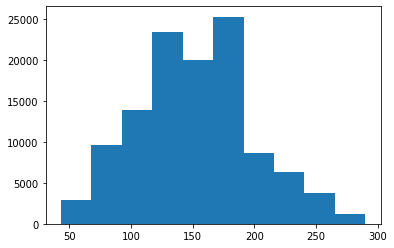

In [27]:
jday = 1

# look at jday = 61

hrus["solrad_targets_vals"] = solrad_targets_vals[:,month_of_jday[jday-1]]
print(len(hrus["solrad_targets_vals"]))
#hrus["hru_cossl"] = solrad_targets["hru_cossl"]

print(solrad_targets_vals.shape)
print(min(solrad_targets_vals[:,month_of_jday[jday-1]]),max(solrad_targets_vals[:,month_of_jday[jday-1]]))

print(min(hrus["solrad_targets_vals"]),max(hrus["solrad_targets_vals"]))

plt.hist(solrad_targets_vals[:,month_of_jday[jday-1]])
plt.show()

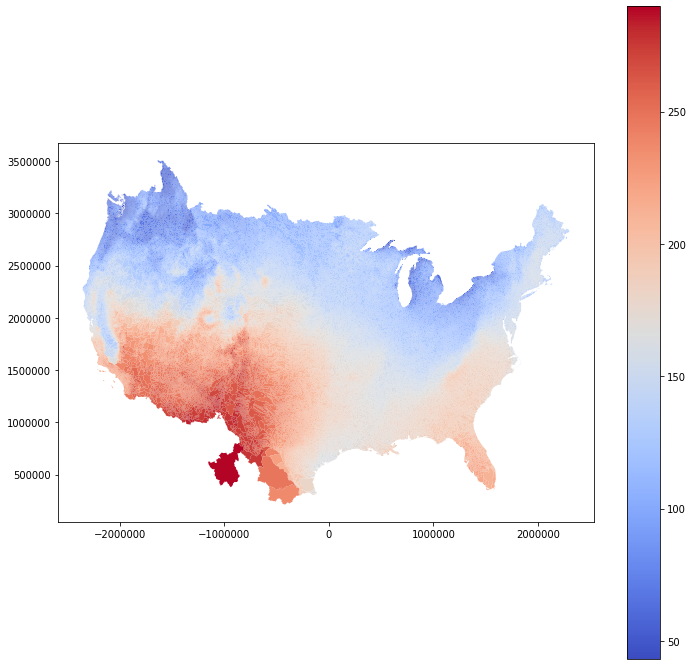

In [28]:
f, ax = plt.subplots(1, figsize=(12, 12))
#hrus.plot(color="white", ax=ax)

# df.dropna(thresh=2)

# plot the HRUs with valid temperature (non-nan) with their color ramp colors
hrus.plot(column='solrad_targets_vals', cmap='coolwarm', ax=ax, legend=True)

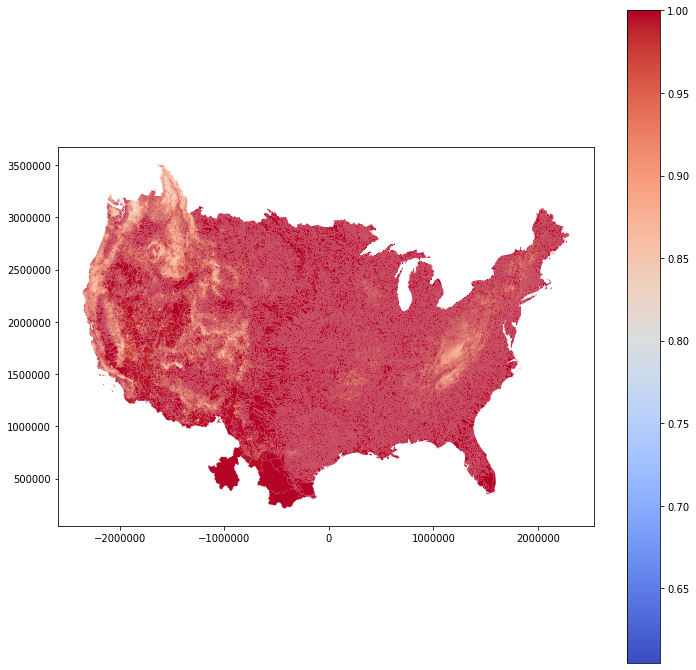

In [21]:
f, ax = plt.subplots(1, figsize=(12, 12))
#hrus.plot(color="white", ax=ax)

# df.dropna(thresh=2)

# plot the HRUs with valid temperature (non-nan) with their color ramp colors
hrus.plot(column='hru_cossl', cmap='coolwarm', ax=ax, legend=True)

In [29]:
hrus["radadj"] = radadj[jday - 1,:]
print(hrus.head)

<bound method NDFrame.head of           OBJECTID  hru_segmen  nhm_id  hru_id_nat Version     Shape_Leng  \
nhru_v11                                                                    
76127          1.0       40038   76128       76128       1   92601.509382   
76147          2.0       40038   76148       76148       1   60460.683381   
76170          3.0       40021   76171       76171       1   62333.253245   
76172          4.0       40019   76173       76173       1   36798.115971   
76181          5.0       40019   76182       76182       1   31441.172667   
...            ...         ...     ...         ...     ...            ...   
57964     114954.0       31028   57965       57965       1  144351.031108   
64080     114955.0       28886   64081       64081       1   79361.919882   
64150     114956.0       28866   64151       64151       1   95810.806831   
65633     114957.0       31412   65634       65634       1   83210.535851   
18843     114958.0       10081   18844       1

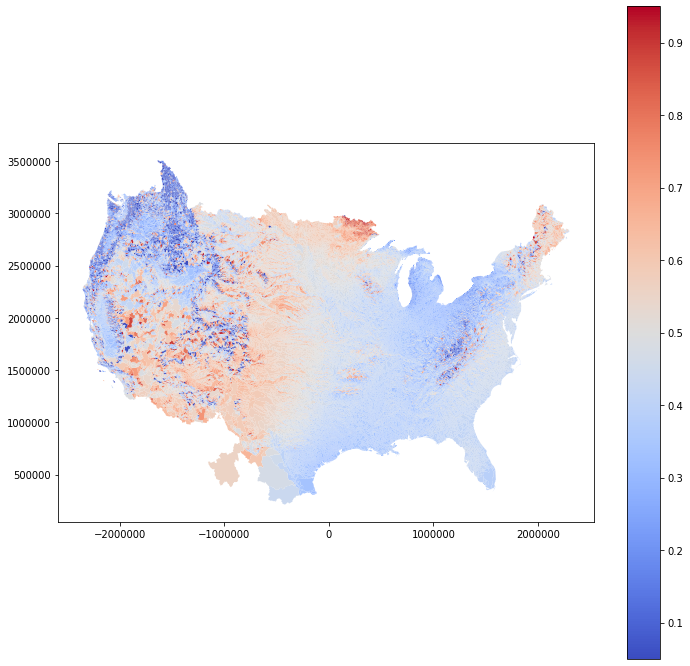

In [30]:
# plot the radadj values

# plot all HRUs in white (background color)
f, ax = plt.subplots(1, figsize=(12, 12))
#hrus.plot(color="white", ax=ax)

# df.dropna(thresh=2)

# plot the HRUs with valid temperature (non-nan) with their color ramp colors
hrus.plot(column='radadj', cmap='coolwarm', ax=ax, legend=True)
#hrus.plot(column='tavgc_2013_10_1', cmap='coolwarm', ax=ax, legend=True)